In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import os

import plotting

try:
    from ecco_pipeline.conf.global_settings import GRIDS, OUTPUT_DIR
    from ecco_pipeline.utils.file_utils import get_date
    import ecco_pipeline.transformations.transformation as Transformation
except:
    os.chdir(os.path.realpath(os.path.join(os.path.abspath(''), '../../..')))
    from ecco_pipeline.conf.global_settings import GRIDS, OUTPUT_DIR
    from ecco_pipeline.utils.file_utils import get_date
    import ecco_pipeline.transformations.transformation as Transformation

In [2]:
ds_name = "AVHRR_OI-NCEI-L4-GLOB-v2.0"
hemisphere = ''
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/AVHRR_OI-NCEI-L4-GLOB-v2.0/harvested_granules/2012/20120109120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.0.nc.nc4


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:           (time: 1, lat: 720, lon: 1440, nv: 2)
Coordinates:
  * time              (time) datetime64[ns] 2012-01-09
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Dimensions without coordinates: nv
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    lat_bnds          (lat, nv) float32 ...
    lon_bnds          (lon, nv) float32 ...
    time_bnds         (time, nv) datetime64[ns] ...
Attributes: (12/48)
    product_version:                 Version 2.0
    spatial_resolution:              0.25 degree
    Conventions:                     CF-1.6,ACDD-1.3
    title:                           NCEI global 0.25 deg daily sea surface t...
    references:                      Reynolds, et al.(2009) What is New in Ve...
    institution:                     NCEI
    ...                              ...
    source:                          NAVO-L2P-AVHRR19_G,NAVO-L2P-AVHRRMTA_G,G...
    summary:                         NOAA's 1/4-degree Daily Optimum Interpol...
    time_coverage_start:             20120109T000000Z
    time_coverage_end:               20120110T000000Z
    uuid:                            368cc228-fe7a-4b67-8eef-923b120675c7
    DODS_EXTRA.Unlimited_Dimension:  time

# Load grid

In [5]:
grids = glob(f'grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/grid_tpose6_radius.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
grid_ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation.Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(grid_ds)

/Users/marlis/opt/anaconda3/envs/ecco_pipeline/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Only using 100 nearest neighbours, but you may need up to 6375938


/Users/marlis/opt/anaconda3/envs/ecco_pipeline/lib/python3.10/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 100 neighbours within 77123 m for some data points
  warnings.warn(('Possible more than %s neighbours '


0 %
5 %
10 %
15 %
21 %
26 %
31 %
36 %
42 %
47 %
52 %
57 %
63 %
68 %
73 %
78 %
84 %
89 %
94 %


# Transformation

In [9]:
field_ds_list = T.transform(grid_ds, factors, ds, config)

In [10]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                                  (time: 1, tile: 13, j: 90, i: 90,
                                              nv: 2)
Coordinates:
  * time                                     (time) datetime64[ns] 2012-01-08...
  * tile                                     (tile) int16 0 1 2 3 ... 9 10 11 12
  * j                                        (j) int16 0 1 2 3 4 ... 86 87 88 89
  * i                                        (i) int16 0 1 2 3 4 ... 86 87 88 89
    XC                                       (tile, j, i) float32 -111.6 ... ...
    YC                                       (tile, j, i) float32 -88.24 ... ...
    time_bnds                                (time, nv) datetime64[ns] 2012-0...
Dimensions without coordinates: nv
Data variables:
    analysed_sst_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9.969...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       GHRSST Level 4 AVHRR_OI Global Blended Sea ...
    original_dataset_short_name:  AVHRR_OI-NCEI-L4-GLOB-v2.0
    original_dataset_url:         https://podaac.jpl.nasa.gov/dataset/AVHRR_O...
    original_dataset_reference:   http://www.earth-syst-sci-data.net/8/165/2016/
    original_dataset_doi:         10.5067/GHAAO-4BC02
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.4
    notes:

# Visualization

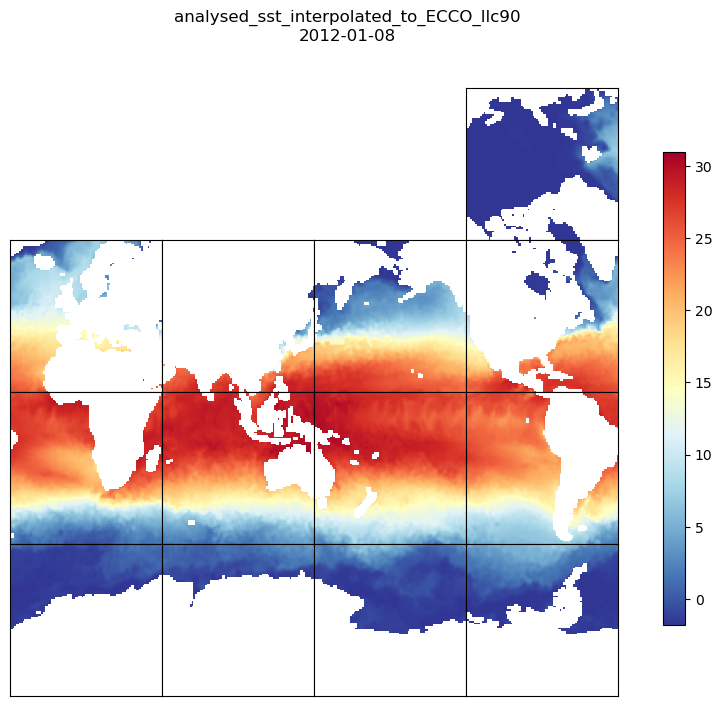

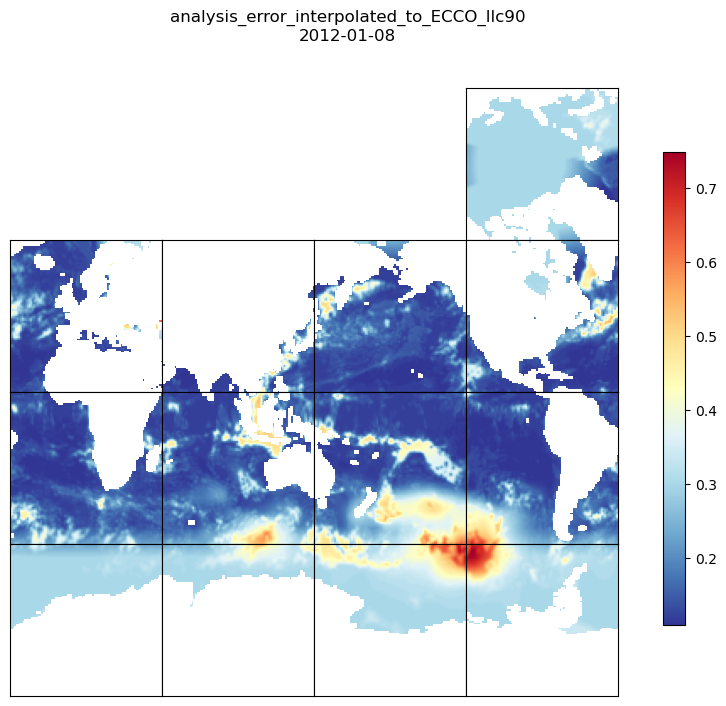

In [11]:
for field_ds in field_ds_list:
    plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]])
